<a href="https://colab.research.google.com/github/AleCava01/Synthesizing-the-Mind/blob/main/Guided_Diffusion_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guided Diffusion testing

Author: Alessandro Cavalieri

This is an elaboration of [Guided Diffusion by OpenAI from scratch](https://www.kaggle.com/code/vikramsandu/guided-diffusion-by-openai-from-scratch/notebook), used by me to understand Diffusion Models, in particular to learn [Guided Diffusion](https://github.com/openai/guided-diffusion) by OpenAI.

In [120]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

## Sample timesteps

In [121]:
import math
import numpy as np

def sample_timesteps(num_total_timesteps: int = 1000,
                     num_sample_timesteps: int = 1000
                    ):
    """
    Uniformaly sample num_sample_timesteps timesteps given total number of timesteps.
    Later we will utilize for speed up sampling.
    """
    # Get New sampled timesteps (Uniform stepping)
    step_size = num_total_timesteps//num_sample_timesteps
    use_timesteps = np.arange(0, num_total_timesteps, step_size)

    # Make sure to append final timestep if not there already
    if (num_total_timesteps - 1) not in use_timesteps:
        use_timesteps = np.append(use_timesteps, num_total_timesteps - 1)

    return use_timesteps


## Cosine Noise Scheduler
calculates the betas based on a cosine schedule, which is a smoother function compared to a linear schedule. The idea is to have smaller betas initially (less noise) and gradually increase them, peaking toward the end of the diffusion process, which ensures that the reverse process can be more effectively learned by the model.


### Alpha bars

$$\bar\alpha_t=\frac{f(t)}{f(0)}, \quad \quad f(t)=\cos\Big (\frac{t/T+s}{1+s}\cdot \frac{\pi}2\Big )^2$$

In [122]:
def get_alpha_bars(num_original_timesteps: int = 1000, num_sampling_timesteps: int = 1000) -> np.ndarray:
  # s is set to 0.008 by Authors
    s = 0.008

    # Calculate alpha bars
    alpha_bars = [
        math.cos(((t / num_original_timesteps + s) / (1 + s)) * (math.pi / 2)) ** 2
        for t in range(num_original_timesteps + 1)
    ]

    return np.array(alpha_bars)


Alpha bars represent the total amount of signal preserved after t steps.

$\bar \alpha_0 = 1$: full signal (original image, no noise)

$\bar \alpha_T = 0$: full noise

So they give you a smooth curve from clean image to pure noise, and the cosine function makes this transition gentle at the beginning, steeper later — which is empirically good for both training and sampling.

Let's take a look:

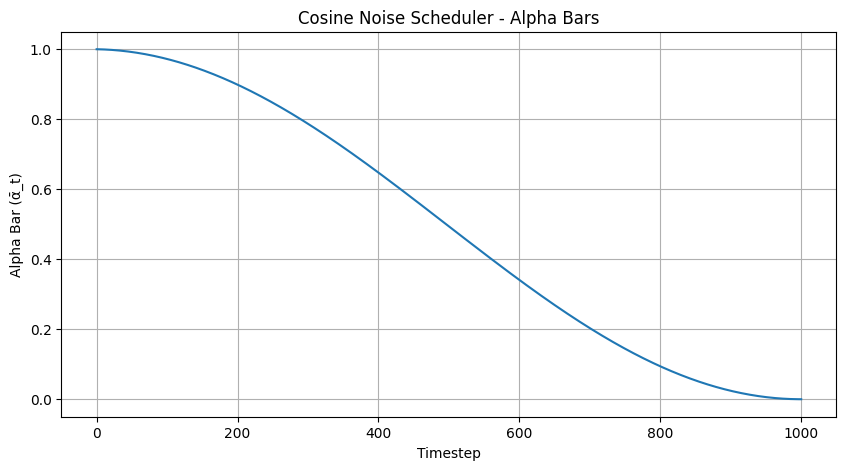

In [123]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Get alpha bars and plot them
alpha_bars = get_alpha_bars()
plt.figure(figsize=(10, 5))
plt.plot(alpha_bars)
plt.title("Cosine Noise Scheduler - Alpha Bars")
plt.xlabel("Timestep")
plt.ylabel("Alpha Bar (ᾱ_t)")
plt.grid(True)
plt.show()

### Betas
$$\beta_t = \min \Big (1-\frac{\bar \alpha_t}{\bar \alpha_{t-1}},\beta_{\max}\Big )$$

The betas in this function control the noise process by determining how much noise is added at each timestep of the diffusion.

In [124]:
def get_betas(alpha_bars: np.ndarray, max_beta: float = 0.999) -> np.ndarray:
  betas = np.array([
        min(1 - a_t / a_tminus1, max_beta)
        for a_t, a_tminus1 in zip(alpha_bars[1:], alpha_bars[:-1])
    ])
  return betas

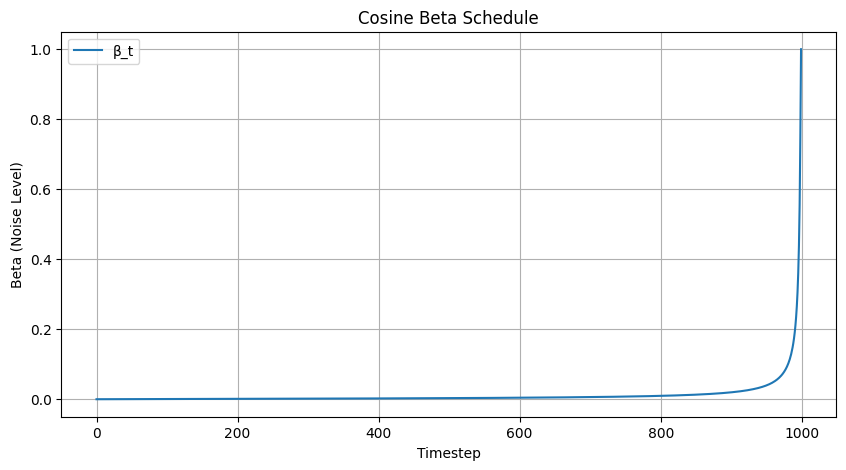

In [125]:
alpha_bars = get_alpha_bars()
betas = get_betas(alpha_bars)

# Plot the beta schedule
plt.figure(figsize=(10, 5))
plt.plot(betas, label="β_t")
plt.xlabel("Timestep")
plt.ylabel("Beta (Noise Level)")
plt.title("Cosine Beta Schedule")
plt.grid(True)
plt.legend()
plt.show()

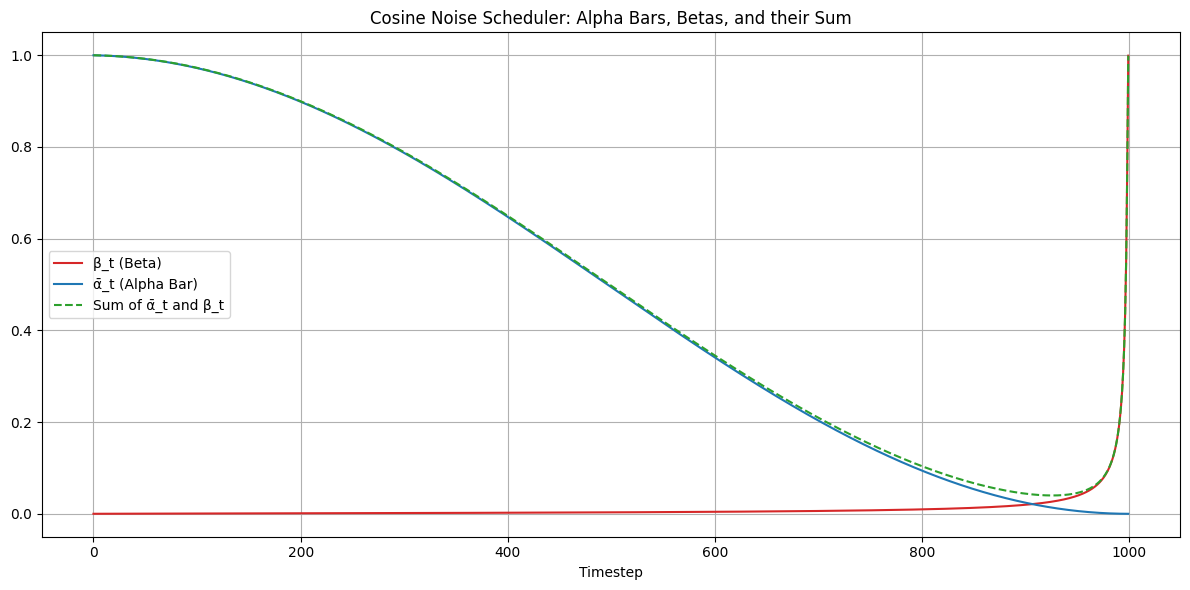

In [126]:
# Compute the sum of alpha_bars and betas
sum_values = alpha_bars[:-1] + betas  # alpha_bars[:-1] aligns the length with betas

# Plot both on the same figure
plt.figure(figsize=(12, 6))
plt.plot(betas, label="β_t (Beta)", color="tab:red")
plt.plot(alpha_bars[:-1], label="ᾱ_t (Alpha Bar)", color="tab:blue")
plt.plot(sum_values, label="Sum of ᾱ_t and β_t", color="tab:green", linestyle="--")
plt.xlabel("Timestep")
plt.title("Cosine Noise Scheduler: Alpha Bars, Betas, and their Sum")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Cosine Noise Scheduler (new betas)

In [127]:
def cosine_noise_schedular(num_original_timesteps: int = 1000,
                           num_sampling_timesteps: int = 1000,
                           max_beta: float = 0.999
                          ) -> np.ndarray:
    """
    Calculate noise controlling parameter betas for all time steps
    according to the cosine noise scheduler.

    Parameters:
    num_original_timesteps (int): Number of original diffusion timesteps (used during training).
    num_sampling_timesteps (int): Number of timesteps used for sampling.
    max_beta (float): Maximum value for beta.

    Returns:
    array: Beta values for each timestep.
    array: timesteps used to calculate betas.

    NOTE: Set "num_sampling_timesteps" = "num_original_timesteps" during training.
    """

    # Get the alpha bars
    alpha_bars = get_alpha_bars(num_original_timesteps, num_sampling_timesteps)

    # Calculate betas
    betas = get_betas(alpha_bars, max_beta)

    # Modify Betas as described in the "Improved Sampling Speed" section above.
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas, axis=0)

    # Get New sampled timesteps (Uniform stepping)
    use_timesteps = sample_timesteps(num_original_timesteps,
                                     num_sampling_timesteps
                                    )

    # Calculate new betas according to new timesteps.
    last_alpha_cumprod = 1.0
    new_betas = []
    for i, alpha_cumprod in enumerate(alphas_cumprod):
        if i in use_timesteps:
            new_betas.append(1 - alpha_cumprod / last_alpha_cumprod)
            last_alpha_cumprod = alpha_cumprod

    return np.array(new_betas), use_timesteps


Let's take a look:

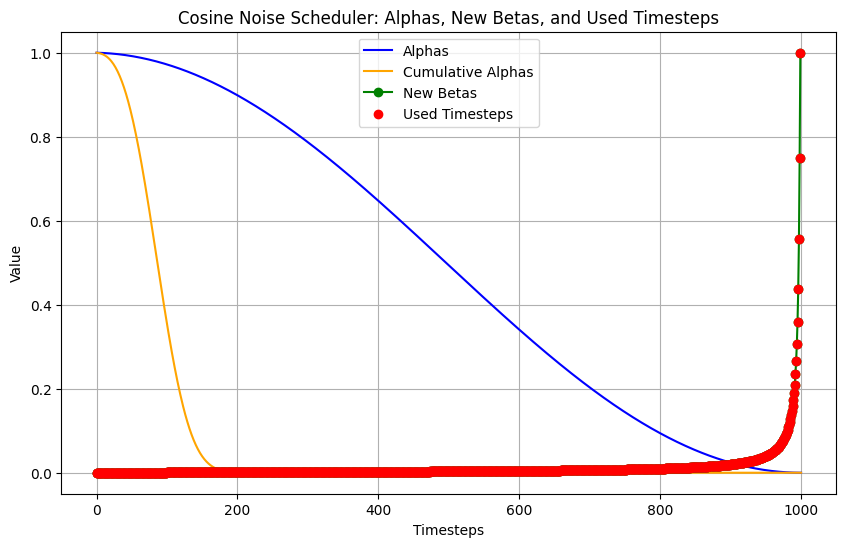

In [128]:
[new_betas, use_timesteps] = cosine_noise_schedular()
alphas_cumprod = np.cumprod(alpha_bars, axis=0)

# Plotting
plt.figure(figsize=(10, 6))

# Plot alphas
plt.plot(alpha_bars, label='Alphas', color='blue')

# Plot cumulative alphas
plt.plot(alphas_cumprod, label='Cumulative Alphas', color='orange')

# Plot new betas
plt.plot(range(len(new_betas)), new_betas, label='New Betas', color='green', marker='o')

# Highlight used timesteps
plt.scatter(use_timesteps, [new_betas[i] for i in range(len(new_betas))], color='red', zorder=5, label='Used Timesteps')

plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.legend(loc='best')
plt.title('Cosine Noise Scheduler: Alphas, New Betas, and Used Timesteps')
plt.grid(True)
plt.show()

## Variational Lower Bound Loss

In [129]:
"""
Helpers for various likelihood-based losses. These are ported from the original
Ho et al. diffusion models codebase:
https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/utils.py
"""

import numpy as np

import torch


def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    Compute the KL divergence between two gaussians.

    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, torch.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for th.exp().
    logvar1, logvar2 = [
        x if isinstance(x, torch.Tensor) else torch.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + torch.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * torch.exp(-logvar2)
    )


def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the
    standard normal.
    """
    return 0.5 * (1.0 + torch.tanh(np.sqrt(2.0 / np.pi) * (x + 0.044715 * torch.pow(x, 3))))


def discretized_gaussian_log_likelihood(x, *, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image.

    :param x: the target images. It is assumed that this was uint8 values,
              rescaled to the range [-1, 1].
    :param means: the Gaussian mean Tensor.
    :param log_scales: the Gaussian log stddev Tensor.
    :return: a tensor like x of log probabilities (in nats).
    """
    assert x.shape == means.shape == log_scales.shape
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1.0 / 255.0)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1.0 / 255.0)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = torch.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(
        x < -0.999,
        log_cdf_plus,
        torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(cdf_delta.clamp(min=1e-12))),
    )
    assert log_probs.shape == x.shape
    return log_probs

def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


## Guided Diffusion Process

In [130]:
import torch.nn.functional as F

class GuidedDiffusionProcess:
    """
    Utilities for training and sampling diffusion model.
    Ported directly from https://github.com/openai/guided-diffusion/blob/main/guided_diffusion/gaussian_diffusion.py
    and modified for simplicity.
    """
    def __init__(self,
                 num_timesteps:int = 1000,
                 num_sampling_timesteps:int = 1000,
                 classifier_guidance: bool = False, # True for Classifier Guidance during sampling only.
                 classifier_scale = 1.0 # Weight given to the classifier gradient
                ):

        # Classifier Guidance.
        self.classifier_guidance = classifier_guidance
        self.classifier_scale = classifier_scale

        # Betas using Cosine Noise Schedular
        self.betas, self.use_timesteps = cosine_noise_schedular(num_timesteps, num_sampling_timesteps)
        self.betas = torch.tensor(self.betas, dtype=torch.float32)
        self.use_timesteps = torch.tensor(self.use_timesteps, dtype=torch.float32)

        # Diffusion Process Coefficients.
        self.alphas = 1.0 - self.betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.one_minus_alphas_cumprod = 1.0 - self.alphas_cumprod
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0/self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0/self.alphas_cumprod - 1)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(self.one_minus_alphas_cumprod)
        self.alphas_cumprod_prev = torch.cat((torch.tensor([1.]), self.alphas_cumprod[:-1]))
        self.sqrt_alphas_cumprod_prev = torch.sqrt(self.alphas_cumprod_prev)


        # calculation for forward process "posterior" q(x_{t-1} | x_{t}).
        self.posterior_mean_coef1 = (self.sqrt_alphas_cumprod_prev * self.betas)/self.one_minus_alphas_cumprod
        self.posterior_mean_coef2 = (self.sqrt_alphas * (1.0 - self.alphas_cumprod_prev))/self.one_minus_alphas_cumprod
        self.posterior_variance = (self.betas * (1.0 - self.alphas_cumprod_prev))/(self.one_minus_alphas_cumprod)

        # Calculation for Variation Lower Bound Loss
        # log calculation clipped because the posterior variance is 0 at the
        # beginning of the diffusion chain.
        self.posterior_log_variance_clipped = torch.log(
            torch.cat((self.posterior_variance[1].unsqueeze(0), self.posterior_variance[1:]))
        )

    def add_noise(self, x0, noise, t):

        """
        calculate x_t for all timesteps given input x0 using
        x_t = sqrt(abar_t) * x0 + sqrt(1 - abar_t) * epsilon
        where epsilon ~ N(0, 1). i.e., Forward Process

        Parameters:
        x0: Batch of Input Images of shape -> (B, C, H, W)
        noise: Batch of Noise sampled from N(0, 1) of shape -> (B, C, H, W)
        t: Batch of timesteps of shape -> (B, 1)

        Return:
        xt: Batch of output images at timesteps t obtained
        according to Diffusion Forward Process of shape -> (B, C, H, W)
        """
        # Mapping to Device + Broadcast
        sqrt_alphas_cumprod = self._coeff_broadcasting(self.sqrt_alphas_cumprod, t)
        sqrt_one_minus_alphas_cumprod = self._coeff_broadcasting(self.sqrt_one_minus_alphas_cumprod, t)

        # Return
        return (sqrt_alphas_cumprod * x0) + (sqrt_one_minus_alphas_cumprod * noise)

    def q_posterior_mean_variance(self, x0, xt, t):

        """
        Calculate Posterior Forward Mean and Variance of the
        Diffusion Process. i.e., q(x_(t-1)|x_t) Later we will use
        this in defining Variational Lower Bound (VLB) loss.

        Parameters:
        x0: Batch of Input Images of shape -> (B, C, H, W)
        xt: Batch of images at timesteps t -> (B, C, H, W)
        t: Batch of timesteps of shape -> (B, 1)

        Return:
        posterior_mean, posterior_variance, and posterior_log_variance_clipped
        of the shape -> (B, C, H, W)
        """

        posterior_mean_coef1 = self._coeff_broadcasting(self.posterior_mean_coef1, t)
        posterior_mean_coef2 = self._coeff_broadcasting(self.posterior_mean_coef2, t)
        posterior_variance = self._coeff_broadcasting(self.posterior_variance, t)
        posterior_log_variance_clipped = self._coeff_broadcasting(self.posterior_log_variance_clipped, t)

        # Posterior Mean
        posterior_mean = (posterior_mean_coef1 * x0) + (posterior_mean_coef2 * xt)

        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, model, x, t, y):

        """
        Calculation of Mean and Variance of p(x_(t-1)|x_t) using
        model noise prediction.

        Params
        --------
        model: U-net model which predicts the noise
        x: signal at time step t of shape -> (B, C, H, W)
        t: Batch of timesteps of shape -> (B, 1)
        y: Batch of class labels of shape -> (B, 1)

        Return
        --------
        mean: the model mean output
        variance: the model variance output
        log_variance: the log of variance
        x0: prediction of x_start
        """
        B, C, H, W = x.shape

        out = model(x, self.scale_timestep(t), y) # Class conditional

        # Get Noise pred and Variance from out
        noise_pred, model_var_values = torch.split(out, C, dim=1)

        # Calculate x0
        sqrt_recip_alphas_cumprod = self._coeff_broadcasting(self.sqrt_recip_alphas_cumprod, t)
        sqrt_recipm1_alphas_cumprod = self._coeff_broadcasting(self.sqrt_recipm1_alphas_cumprod, t)
        pred_xstart = (sqrt_recip_alphas_cumprod * x) - (sqrt_recipm1_alphas_cumprod * noise_pred)
        pred_xstart = torch.clamp(pred_xstart, -1., 1.)

        # Calculate Mean
        model_mean, _, _ = self.q_posterior_mean_variance(pred_xstart, x, t)

        # Calculate Variance
        min_log_var = self._coeff_broadcasting(self.posterior_log_variance_clipped, t)
        max_log_var = self._coeff_broadcasting(torch.log(self.betas), t)
        frac = (model_var_values + 1)/2 # Convert the model_var_values from [-1, 1] -> [0, 1]
        model_log_variance = (frac * max_log_var) + ((1-frac) * min_log_var)
        model_variance = torch.exp(model_log_variance)

        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart
        }

    def p_sample(self, model, x, t, y, classifier=None):

        """
        sample x_{t-1} from the model at given timestep.
        """
        out = self.p_mean_variance(model, x.float(), t, y)

        noise = torch.randn_like(x)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0

        # Shift the mean to Sigma * gradient
        if self.classifier_guidance:
            gradient = self._calc_gradient(x, self.scale_timestep(t), y, classifier) * self.classifier_scale
            out["mean"] = out["mean"].float() + out["variance"] * gradient.float()

        sample = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise

        return {"sample": sample, "pred_xstart": out["pred_xstart"]}


    def _vb_terms_bpd(
        self, model, x_start, x_t, t, y
    ):
        """
        Get a term for the variational lower-bound.

        The resulting units are bits (rather than nats, as one might expect).
        This allows for comparison to other papers.

        :return: a dict with the following keys:
                 - 'output': a shape [N] tensor of NLLs or KLs.
                 - 'pred_xstart': the x_0 predictions.
        """
        true_mean, _, true_log_variance_clipped = self.q_posterior_mean_variance(
            x0=x_start, xt=x_t, t=t
        )
        out = self.p_mean_variance(
            model, x_t, t, y
        )
        kl = normal_kl(
            true_mean, true_log_variance_clipped, out["mean"], out["log_variance"]
        )
        kl = mean_flat(kl) / np.log(2.0)

        decoder_nll = -discretized_gaussian_log_likelihood(
            x_start, means=out["mean"], log_scales=0.5 * out["log_variance"]
        )
        assert decoder_nll.shape == x_start.shape
        decoder_nll = mean_flat(decoder_nll) / np.log(2.0)

        # At the first timestep return the decoder NLL,
        # otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
        output = torch.where((t == 0), decoder_nll, kl)
        return {"output": output, "pred_xstart": out["pred_xstart"]}

    def training_losses(self, model, x_start, t, noise, y):
        """
        MSE Loss and Variational Lower Bound Loss.
        """
        x_t = self.add_noise(x_start, noise, t)
        model_output = model(x_t.float(), self.scale_timestep(t), y)

        # Model Output and Variance
        B, C, H, W = x_start.shape
        model_output, model_var_values = torch.split(model_output, C, dim=1)

        # Learn the variance using the variational bound, but don't let
        # it affect our mean prediction.
        frozen_out = torch.cat([model_output.detach(), model_var_values], dim=1)
        vlb_loss = self._vb_terms_bpd(
            model=lambda *args, r=frozen_out: r,
            x_start=x_start,
            x_t=x_t,
            t=t,
            y=y
        )["output"]

        # Divide by 1000 for equivalence with initial implementation.
        # Without a factor of 1/1000, the VB term hurts the MSE term.
        #vlb_loss *= 1 / 1000.0

        # MSE Loss
        mse_loss = mean_flat((noise - model_output) ** 2)

        return { "mse_loss": mse_loss, "vlb_loss": vlb_loss}

    def scale_timestep(self, timestep):
        """
        This is to make sure we are feeding correct timestep
        to the model. (comes handy during sampling with lower timesteps)
        """
        return torch.tensor([self.use_timesteps.to(timestep.device)[int(t)].item() for t in timestep], device=timestep.device)

    @staticmethod
    def _calc_gradient(x, t, y, classifier):
        """
        Calculate Classifier Gradient of the image x at timestep t.
        """
        with torch.enable_grad():
            x_in = x.detach().requires_grad_(True)
            logits = classifier(x_in, t)
            log_probs = F.log_softmax(logits, dim=-1)
            selected = log_probs[range(len(logits)), y.view(-1)]
            return torch.autograd.grad(selected.sum(), x_in)[0]


    @staticmethod
    def _coeff_broadcasting(coeff, timesteps):

        """
        Device Mapping and Broadcasting of the Diffusion
        Process Coefficients to the same shape as Input tensors
        (B, C, H, W).
        """

        # Make coef on the same device as timesteps
        coeff = coeff.to(timesteps.device)[timesteps.long()]

        # Broadcast
        coeff = coeff[:,None, None, None]

        return coeff



## UNet Architecture

### Utility Modules

In [133]:
def get_time_embedding(
    time_steps: torch.Tensor,
    t_emb_dim: int
) -> torch.Tensor:

    """
    Transform a scalar time-step into a vector representation of size t_emb_dim.

    :param time_steps: 1D tensor of size -> (Batch,)
    :param t_emb_dim: Embedding Dimension -> for ex: 128 (scalar value)

    :return tensor of size -> (B, t_emb_dim)
    """

    assert t_emb_dim%2 == 0, "time embedding must be divisible by 2."

    factor = 2 * torch.arange(start = 0,
                              end = t_emb_dim//2,
                              dtype=torch.float32,
                              device=time_steps.device
                             ) / (t_emb_dim)

    factor = 10000**factor

    t_emb = time_steps[:,None] # B -> (B, 1)
    t_emb = t_emb/factor # (B, 1) -> (B, t_emb_dim//2)
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=1) # (B , t_emb_dim)

    return t_emb


In [134]:
import torch.nn as nn

class NormActConv(nn.Module):
    """
    Perform GroupNorm, Activation, and Convolution operations.
    """
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 num_groups:int = 8,
                 kernel_size: int = 3,
                 norm:bool = True,
                 act:bool = True
                ):
        super(NormActConv, self).__init__()

        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            in_channels
        ) if norm is True else nn.Identity()

        # Activation
        self.act = nn.SiLU() if act is True else nn.Identity()

        # Convolution
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            padding=(kernel_size - 1)//2
        )

    def forward(self, x):
        x = self.g_norm(x)
        x = self.act(x)
        x = self.conv(x)
        return x

    # Making this class subscriptable for later use.
    def __getitem__(self, index):
        if index == 0:
            return self.g_norm
        elif index == 1:
            return nn.Sequential(self.act,
                                 self.conv
                                )
        else:
            raise IndexError('Index out of range. Valid indices are 0, 1')

#-----------------------------------------------------------------

class TimeEmbedding(nn.Module):
    """
    Maps the Time Embedding to the Required output Dimension.
    """
    def __init__(self,
                 n_out:int, # Output Dimension
                 t_emb_dim:int = 128 # Time Embedding Dimension
                ):
        super(TimeEmbedding, self).__init__()

        # Time Embedding Block
        self.te_block = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, n_out)
        )

    def forward(self, x):
        return self.te_block(x)

#---------------------------------------------------------------

class SelfAttentionBlock(nn.Module):
    """
    Perform GroupNorm and Multiheaded Self Attention operation.
    """
    def __init__(self,
                 num_channels:int,
                 num_groups:int = 8,
                 num_heads:int = 4,
                 norm:bool = True
                ):
        super(SelfAttentionBlock, self).__init__()

        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            num_channels
        ) if norm is True else nn.Identity()

        # Self-Attention
        self.attn = nn.MultiheadAttention(
            num_channels,
            num_heads,
            batch_first=True
        )

    def forward(self, x):
        batch_size, channels, h, w = x.shape
        x = x.reshape(batch_size, channels, h*w)
        x = self.g_norm(x)
        x = x.transpose(1, 2)
        x, _ = self.attn(x, x, x)
        x = x.transpose(1, 2).reshape(batch_size, channels, h, w)
        return x

#----------------------------------------------------------------

class Downsample(nn.Module):
    """
    Perform Downsampling by the factor of k across Height and Width.
    """
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 k:int = 2, # Downsampling factor
                 use_conv:bool = True, # If Downsampling using conv-block
                 use_mpool:bool = True # If Downsampling using max-pool
                ):
        super(Downsample, self).__init__()

        self.use_conv = use_conv
        self.use_mpool = use_mpool

        # Downsampling using Convolution
        self.cv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_mpool else out_channels,
                kernel_size=4,
                stride=k,
                padding=1
            )
        ) if use_conv else nn.Identity()

        # Downsampling using Maxpool
        self.mpool = nn.Sequential(
            nn.MaxPool2d(k, k),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_conv else out_channels,
                kernel_size=1,
                stride=1,
                padding=0
            )
        ) if use_mpool else nn.Identity()

    def forward(self, x):

        if not self.use_conv:
            return self.mpool(x)

        if not self.use_mpool:
            return self.cv(x)

        return torch.cat([self.cv(x), self.mpool(x)], dim=1)

#-----------------------------------------------------------------------

class Upsample(nn.Module):
    """
    Perform Upsampling by the factor of k across Height and Width
    """
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 k:int = 2, # Upsampling factor
                 use_conv:bool = True, # Upsampling using conv-block
                 use_upsample:bool = True # Upsampling using nn.upsample
                ):
        super(Upsample, self).__init__()

        self.use_conv = use_conv
        self.use_upsample = use_upsample

        # Upsampling using conv
        self.cv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels//2 if use_upsample else out_channels,
                kernel_size=4,
                stride=k,
                padding=1
            ),
            nn.Conv2d(
                out_channels//2 if use_upsample else out_channels,
                out_channels//2 if use_upsample else out_channels,
                kernel_size = 1,
                stride=1,
                padding=0
            )
        ) if use_conv else nn.Identity()

        # Upsamling using nn.Upsample
        self.up = nn.Sequential(
            nn.Upsample(
                scale_factor=k,
                mode = 'bilinear',
                align_corners=False
            ),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_conv else out_channels,
                kernel_size=1,
                stride=1,
                padding=0
            )
        ) if use_upsample else nn.Identity()

    def forward(self, x):

        if not self.use_conv:
            return self.up(x)

        if not self.use_upsample:
            return self.cv(x)

        return torch.cat([self.cv(x), self.up(x)], dim=1)


### DownC block

In [135]:
class DownC(nn.Module):
    """
    Perform Down-convolution on the input using following approach.
    1. Conv + TimeEmbedding
    2. Conv
    3. Skip-connection from input x.
    4. Self-Attention
    5. Skip-Connection from 3.
    6. Downsampling
    """
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int=2,
                 down_sample:bool = True, # True for Downsampling
                 use_scale_shift_norm:bool = True # Use scale shift norm
                ):
        super(DownC, self).__init__()

        self.num_layers = num_layers
        self.use_scale_shift_norm = use_scale_shift_norm

        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels,
                        out_channels
                       ) for i in range(num_layers)
        ])

        self.conv2 = nn.ModuleList([
            NormActConv(out_channels,
                        out_channels
                       ) for _ in range(num_layers)
        ])

        self.te_block = nn.ModuleList([
            TimeEmbedding(2 * out_channels if use_scale_shift_norm else out_channels,
                          t_emb_dim
                         ) for _ in range(num_layers)
        ])

        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])

        self.down_block =Downsample(out_channels, out_channels) if down_sample else nn.Identity()

        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels,
                out_channels,
                kernel_size=1
            ) for i in range(num_layers)
        ])

    def forward(self, x, t_emb):

        out = x

        for i in range(self.num_layers):
            resnet_input = out

            # Resnet Block
            out = self.conv1[i](out)
            emb_out = self.te_block[i](t_emb)[:, :, None, None]
            if self.use_scale_shift_norm:
                out_norm, out_rest = self.conv2[i][0], self.conv2[i][1]
                scale, shift = torch.chunk(emb_out, 2, dim=1)
                out = out_norm(out) * (1 + scale) + shift
                out = out_rest(out)
            else:
                out = out + emb_out
                out = self.conv2[i](out)

            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

        # Downsampling
        out = self.down_block(out)

        return out


### MidC block

In [136]:
class MidC(nn.Module):
    """
    Refine the features obtained from the DownC block.
    It refines the features using following operations:

    1. Resnet Block with Time Embedding
    2. A Series of Self-Attention + Resnet Block with Time-Embedding
    """
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 t_emb_dim:int = 128,
                 num_layers:int = 2,
                 use_scale_shift_norm:bool = True # Use scale shift norm
                ):
        super(MidC, self).__init__()

        self.num_layers = num_layers
        self.use_scale_shift_norm = use_scale_shift_norm

        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels,
                        out_channels
                       ) for i in range(num_layers + 1)
        ])

        self.conv2 = nn.ModuleList([
            NormActConv(out_channels,
                        out_channels
                       ) for _ in range(num_layers + 1)
        ])

        self.te_block = nn.ModuleList([
            TimeEmbedding(2 * out_channels if use_scale_shift_norm else out_channels,
                          t_emb_dim
                         ) for _ in range(num_layers + 1)
        ])

        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])

        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels,
                out_channels,
                kernel_size=1
            ) for i in range(num_layers + 1)
        ])

    def forward(self, x, t_emb):
        out = x

        # First-Resnet Block
        resnet_input = out

        # Resnet Block
        out = self.conv1[0](out)
        emb_out = self.te_block[0](t_emb)[:, :, None, None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.conv2[0][0], self.conv2[0][1]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            out = out_norm(out) * (1 + scale) + shift
            out = out_rest(out)
        else:
            out = out + emb_out
            out = self.conv2[0](out)

        out = out + self.res_block[0](resnet_input)


        # Sequence of Self-Attention + Resnet Blocks
        for i in range(self.num_layers):

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

            # Resnet Block
            resnet_input = out
            out = self.conv1[i+1](out)
            emb_out = self.te_block[i+1](t_emb)[:, :, None, None]
            if self.use_scale_shift_norm:
                out_norm, out_rest = self.conv2[i+1][0], self.conv2[i+1][1]
                scale, shift = torch.chunk(emb_out, 2, dim=1)
                out = out_norm(out) * (1 + scale) + shift
                out = out_rest(out)
            else:
                out = out + emb_out
                out = self.conv2[i+1](out)

            out = out + self.res_block[i+1](resnet_input)

        return out


### UpC block

In [137]:
class UpC(nn.Module):
    """
    Perform Up-convolution on the input using following approach.
    1. Upsampling
    2. Conv + TimeEmbedding
    3. Conv
    4. Skip-connection from 1.
    5. Self-Attention
    6. Skip-Connection from 3.
    """
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int = 2,
                 up_sample:bool = True, # True for Upsampling
                 use_scale_shift_norm:bool = True # Use scale shift norm
                ):
        super(UpC, self).__init__()

        self.num_layers = num_layers
        self.use_scale_shift_norm = use_scale_shift_norm

        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels,
                        out_channels
                       ) for i in range(num_layers)
        ])

        self.conv2 = nn.ModuleList([
            NormActConv(out_channels,
                        out_channels
                       ) for _ in range(num_layers)
        ])

        self.te_block = nn.ModuleList([
            TimeEmbedding(2 * out_channels if use_scale_shift_norm else out_channels,
                          t_emb_dim
                         ) for _ in range(num_layers)
        ])

        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])

        self.up_block =Upsample(in_channels, in_channels//2) if up_sample else nn.Identity()

        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels,
                out_channels,
                kernel_size=1
            ) for i in range(num_layers)
        ])

    def forward(self, x, down_out, t_emb):

        # Upsampling
        x = self.up_block(x)
        x = torch.cat([x, down_out], dim=1)

        out = x
        for i in range(self.num_layers):
            resnet_input = out

            # Resnet Block
            out = self.conv1[i](out)
            emb_out = self.te_block[i](t_emb)[:, :, None, None]
            if self.use_scale_shift_norm:
                out_norm, out_rest = self.conv2[i][0], self.conv2[i][1]
                scale, shift = torch.chunk(emb_out, 2, dim=1)
                out = out_norm(out) * (1 + scale) + shift
                out = out_rest(out)
            else:
                out = out + emb_out
                out = self.conv2[i](out)

            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

        return out


### U-Net

In [138]:
class Unet(nn.Module):
    """
    U-net architecture which is used to predict noise and
    variance defining vector v in the paper
    "Diffusion Models Beat GANs on Image Synthesis".

    U-net consists of Series of DownC blocks followed by MidC
    followed by UpC.
    """

    def __init__(self,
                 im_channels: int = 1, # GRAY
                 down_ch: list = [32, 64, 128, 256],
                 mid_ch: list = [256, 256, 128],
                 up_ch: list[int] = [256, 128, 64, 16],
                 down_sample: list[bool] = [True, True, False],
                 t_emb_dim: int = 128,
                 num_downc_layers:int = 2,
                 num_midc_layers:int = 2,
                 num_upc_layers:int = 2,
                 use_scale_shift_norm:bool = True,
                 num_classes:int = 10 # MNIST
                ):
        super(Unet, self).__init__()

        self.im_channels = im_channels
        self.down_ch = down_ch
        self.mid_ch = mid_ch
        self.up_ch = up_ch
        self.t_emb_dim = t_emb_dim
        self.down_sample = down_sample
        self.num_downc_layers = num_downc_layers
        self.num_midc_layers = num_midc_layers
        self.num_upc_layers = num_upc_layers
        self.use_scale_shift_norm = use_scale_shift_norm
        self.num_classes = num_classes

        self.up_sample = list(reversed(self.down_sample)) # [False, True, True]

        # Initial Convolution
        self.cv1 = nn.Conv2d(self.im_channels, self.down_ch[0], kernel_size=3, padding=1)

        # Initial Time Embedding Projection
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        # Class conditioning
        if self.num_classes is not None:
            self.label_emb = nn.Embedding(self.num_classes, self.t_emb_dim)

        # DownC Blocks
        self.downs = nn.ModuleList([
            DownC(
                self.down_ch[i],
                self.down_ch[i+1],
                self.t_emb_dim,
                self.num_downc_layers,
                self.down_sample[i],
                self.use_scale_shift_norm
            ) for i in range(len(self.down_ch) - 1)
        ])

        # MidC Block
        self.mids = nn.ModuleList([
            MidC(
                self.mid_ch[i],
                self.mid_ch[i+1],
                self.t_emb_dim,
                self.num_midc_layers,
                self.use_scale_shift_norm
            ) for i in range(len(self.mid_ch) - 1)
        ])

        # UpC Block
        self.ups = nn.ModuleList([
            UpC(
                self.up_ch[i],
                self.up_ch[i+1],
                self.t_emb_dim,
                self.num_upc_layers,
                self.up_sample[i],
                self.use_scale_shift_norm
            ) for i in range(len(self.up_ch) - 1)
        ])

        # Final Convolution
        self.cv2 = nn.Sequential(
            nn.GroupNorm(8, self.up_ch[-1]),
            nn.Conv2d(self.up_ch[-1], self.im_channels * 2, kernel_size=3, padding=1)
        )

    def forward(self, x, t, y):

        out = self.cv1(x)

        # Time Projection
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)

        # Class conditional
        if self.num_classes is not None:
            t_emb = t_emb + self.label_emb(y)

        # DownC outputs
        down_outs = []

        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)

        # MidC outputs
        for mid in self.mids:
            out = mid(out, t_emb)

        # UpC Blocks
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)

        # Final Conv
        out = self.cv2(out)

        return out

In [139]:
# Test
model = Unet()
x = torch.randn(1, 1, 32, 32)
t = torch.randint(0, 10, (1,))
y = torch.randint(0, 10, (1,))
model(x, t, y).shape


torch.Size([1, 2, 32, 32])

### UNet classifier

In [140]:
class UnetClassifier(nn.Module):
    """
    U-net Classifier architecture; Almost same as Unet
    architecture except UpC layer.
    1. will be trained on noisy images obtained
    by forward diffusion process and labels.
    2. will be used for classifier guidance
    during sampling process.
    """

    def __init__(self,
                 im_channels: int = 1, # GRAY
                 down_ch: list = [32, 64, 128, 256],
                 mid_ch: list = [256, 256, 128],
                 down_sample: list[bool] = [True, True, False],
                 t_emb_dim: int = 128,
                 num_downc_layers:int = 2,
                 num_midc_layers:int = 2,
                 use_scale_shift_norm:bool = True,
                 num_classes:int = 10 # MNIST
                ):
        super(UnetClassifier, self).__init__()

        self.im_channels = im_channels
        self.down_ch = down_ch
        self.mid_ch = mid_ch
        self.t_emb_dim = t_emb_dim
        self.down_sample = down_sample
        self.num_downc_layers = num_downc_layers
        self.num_midc_layers = num_midc_layers
        self.use_scale_shift_norm = use_scale_shift_norm
        self.num_classes = num_classes

        # Initial Convolution
        self.cv1 = nn.Conv2d(self.im_channels, self.down_ch[0], kernel_size=3, padding=1)

        # Initial Time Embedding Projection
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )


        # DownC Blocks
        self.downs = nn.ModuleList([
            DownC(
                self.down_ch[i],
                self.down_ch[i+1],
                self.t_emb_dim,
                self.num_downc_layers,
                self.down_sample[i],
                self.use_scale_shift_norm
            ) for i in range(len(self.down_ch) - 1)
        ])

        # MidC Block
        self.mids = nn.ModuleList([
            MidC(
                self.mid_ch[i],
                self.mid_ch[i+1],
                self.t_emb_dim,
                self.num_midc_layers,
                self.use_scale_shift_norm
            ) for i in range(len(self.mid_ch) - 1)
        ])

        # Out
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(self.mid_ch[-1], self.num_classes)
        )


    def forward(self, x, t):

        out = self.cv1(x)

        # Time Projection
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)

        for down in self.downs:
            out = down(out, t_emb)

        # MidC outputs
        for mid in self.mids:
            out = mid(out, t_emb)

        return self.head(out)


In [141]:
# Test
model = UnetClassifier()
x = torch.randn(4, 1, 32, 32)
t = torch.randint(0, 10, (4,))
model(x, t).shape


torch.Size([4, 10])

## Training Utilities

### Configuration

In [142]:
# Configuration class
class CONFIG:

    # Save and Load Paths
    train_csv_path = 'drive/MyDrive/PACS/Synthesizing_the_mind/digit-recognizer/train.csv'
    test_csv_path = 'drive/MyDrive/PACS/Synthesizing_the_mind/digit-recognizer/test.csv'
    model_path = 'drive/MyDrive/PACS/Synthesizing_the_mind/diffusion-models/openai_unet.pth'
    classifier_path = 'openai_unet_classifier.pth'
    generated_csv_path = 'mnist_generated_data.csv'

    # Training Hyperparams
    num_epochs = 50
    lr = 1e-4
    num_diffusion_timesteps = 1000
    batch_size = 128
    img_size = 28
    in_channels = 1
    num_classes = 10

    # Sampling Hyperparams
    num_img_to_generate = 256
    num_sampling_timesteps = 1000
    classifier_guidance = False
    classifier_scale = 1.0


### Dataset

In [143]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class PNGImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, filename) for filename in os.listdir(root_dir) if filename.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Convert to RGB if necessary
        if self.transform:
            image = self.transform(image)
        return image


#### data loaders

In [144]:
# Define transformations (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to the desired size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Create dataset and data loaders
dataset = PNGImageDataset(root_dir='drive/MyDrive/PACS/Synthesizing_the_mind/coronal_2D_healthy_IOP_scanner', transform=transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

## Train Classifier

#### Model and Optimizer Initialization

In [145]:
diffusion_process = GuidedDiffusionProcess()
model = Unet(im_channels=3)  # Set im_channels to 3 for RGB images
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#### Training loop

In [149]:
from torch.amp import GradScaler, autocast  # Import GradScaler
# Create a GradScaler for AMP
scaler = GradScaler()

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Enable parallel data loading
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

epochs = 1000
for epoch in range(epochs):
    for batch_idx, images in enumerate(train_loader):
        # Move data to device
        images = images.to(device)

        # Get timesteps and noise
        t = torch.randint(0, diffusion_process.use_timesteps.shape[0], (images.shape[0],), device=device).type(torch.float32)
        noise = torch.randn_like(images, device=device)
        y = torch.randint(0, model.num_classes, (images.shape[0],), device=device) # Dummy labels

        # Enable autocast for mixed precision (with device_type)
        with autocast(device_type='cuda'):
            losses = diffusion_process.training_losses(model, images, t, noise, y)
            loss = losses['mse_loss'] + losses['vlb_loss']  # Assuming losses are tensors
            loss = loss.mean()  # Reduce to a scalar using mean()

        # Scale the loss and backpropagate
        scaler.scale(loss).backward()

        # Unscale the gradients and update optimizer
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

## Synthesize images

In [150]:
def synthesize_images(model, num_images):
    device = next(model.parameters()).device  # Get the model's device
    with torch.no_grad():
        x = torch.randn(num_images, 3, 32, 32, device=device)  # Initialize noise on the device
        y = torch.randint(0, model.num_classes, (num_images,), device=device) # Dummy labels

        for t in reversed(range(1000)):
            # Scale timestep and sample
            t_batch = torch.tensor([t] * num_images, device=device)
            samples = diffusion_process.p_sample(model, x, t_batch, y)
            x = samples["sample"]  # Update x with the sampled tensor

        # Denormalize and convert to PIL images
        x = (x + 1) / 2  # Denormalize to [0, 1]
        images = [transforms.ToPILImage()(img.cpu()) for img in x]  # Move images to CPU for PIL
    return images

In [160]:
synthesized_images = synthesize_images(model, 10)  # Synthesize 10 images


In [161]:
import matplotlib.pyplot as plt

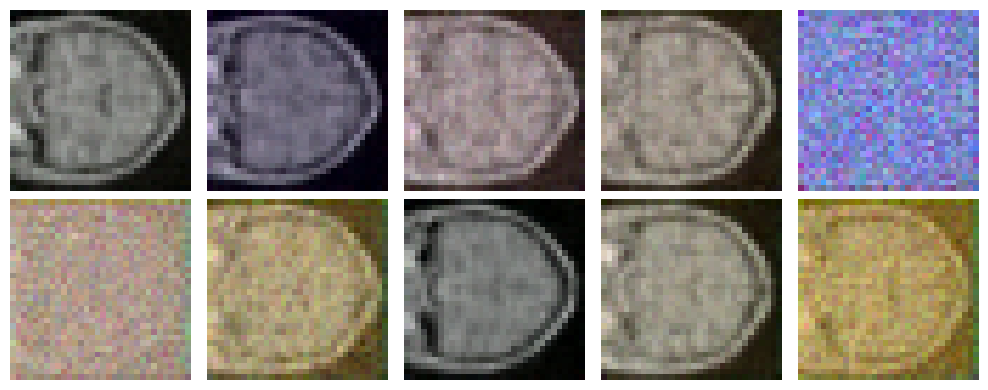

In [162]:
def visualize_images(images, num_rows=2, num_cols=5):
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4))  # Adjust figsize as needed
        for i, image in enumerate(images):
            row = i // num_cols
            col = i % num_cols
            axes[row, col].imshow(image)
            axes[row, col].axis('off')  # Hide axis labels
        plt.tight_layout()
        plt.show()

# Visualize the synthesized images
visualize_images(synthesized_images)